In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pymc3 as pm
import arviz as az
from itertools import combinations as comb
import pandas as pd
from plotly import graph_objects as go

plt.rcParams['figure.figsize'] = (10,8)
plt.style.use('seaborn-darkgrid')

## sample data

In [2]:
home = pd.read_csv('data/home_page_table.csv')
conf = pd.read_csv('data/payment_confirmation_table.csv')
pay = pd.read_csv('data/payment_page_table.csv')
search = pd.read_csv('data/search_page_table.csv')
user = pd.read_csv('data/user_table.csv')

user['date'] = pd.to_datetime(user['date']) # 2015.01~2015.04
user = user.sort_values('date')

# table 하나로 통합
user = user.merge(home, on='user_id', how='left').rename(columns={'page':'home'})
user = user.merge(search, on='user_id', how='left').rename(columns={'page':'search'})
user = user.merge(pay, on='user_id', how='left').rename(columns={'page':'pay'})
user = user.merge(conf, on='user_id', how='left').rename(columns={'page':'conf'})

# 정리
user = user.fillna(0)
user.iloc[:,-4:] = (user.iloc[:,-4:] !=0) *1
data = user.iloc[:,2:]

## Main function

##### report
* plot추가로

##### mab
* 데이터를 저장
* beta 분포가 너무 강함. 약화시켜줄 필요

In [3]:
class report:
    """
    basic 
    """
    def __init__(self, df, condition):
        
        self.data = df
        self.columns = df.columns.tolist()
        self.condition_list = condition
        self.n_condition = len(condition)
        self.stage_list = list(set(self.columns) - set(self.condition_list))
        self.n_stage = self.data.shape[1] - self.n_condition


        temp = self.stage_list.copy()
        temp_total = [self.data[i].sum() for i in temp] # 개별 stage 개수 
        self.stage_order = []        
        self.stage_total = []

        for i in range(self.n_stage):
            self.stage_order.append(temp[np.argmax(temp_total)])
            self.stage_total.append(np.max(temp_total))
            temp.pop(np.argmax(temp_total))
            temp_total.pop(np.argmax(temp_total))
        
        self.alpha = df[self.stage_list] + 1 
        self.beta = df[self.stage_list] 
    
    
            
    def conversion(self,initial,target,criteria):
        
        temp = self.data[[initial,target,criteria]].groupby(criteria).sum()        
        
        conv_ratio = temp[target]/temp[initial]
        print('conversion rate'.center(50))
        for i in range(len(temp)):
            print(f'* group "{conv_ratio.index[i]}": {round(conv_ratio.values[i],4)}')
       
        
        
    def funnel(self, condition):
        """
        input : 
        output : 단계별 전환율/단계별~target전환율
        """
        
        temp = self.data.groupby(condition).sum()[self.stage_order]
        group = self.data.groupby(condition).sum()[self.stage_order].index
        print('Summary'.center(50))
        print(' ')
        print(f'* stage list : {self.stage_order}')
        print(f'* stage size : {self.stage_total}')
        print('* stage portion :' ,['%.2f'%((i/self.stage_total[0])*100) + '%' for i in self.stage_total])
        print(' ')
        print('-----------------------------------------------------')
        print('Number of samples by group'.center(50))
        print(' ')
        for i in range(len(group)):
                print(f'* group "{group[i]}": {temp.values[i]}')        
        print(' ')
        
        stage_ratio = (temp / temp.shift(1,axis=1)).fillna(1)
        target_ratio = temp.apply(lambda x : 1/x).multiply(temp.iloc[:,-1], axis=0)
        print('-----------------------------------------------------')
        print('Stage to stage decay rate'.center(50))
        print(' ')
        for i in range(len(group)):
                print(f'* group "{group[i]}": {np.round(stage_ratio.values[i],3)}')        
            
        print(' ')
        print('-----------------------------------------------------')
        print('Conversion rate in each stage'.center(50))
        print(' ')
        for i in range(len(group)):
                print(f'* group "{group[i]}":' ,['%.2f'%(i*100)+'%' for i in target_ratio.values[i]])
        
                
                
    def absim(self,initial,target, criteria):
        temp = self.data.copy()
        temp = temp.groupby(criteria).sum()
        
        n_crit = len(temp.index)
        name_crit = temp.index
        n_initial = temp[initial].values
        n_target = temp[target].values
        comb_list = comb(range(n_crit), 2)
        
        with pm.Model() as ad_model:
            
            prior = [pm.Beta(f'prior_{name_crit[i]}', alpha=1, beta=1) for i in range(n_crit)]
            likelihood = [pm.Binomial(f'likelihood_{name_crit[i]}', n=n_initial[i], p=prior[i], observed=n_target[i]) for i in range(n_crit)]
            
            diff = [pm.Deterministic(f"diff_{name_crit[i[0]]}_{name_crit[i[1]]}", prior[i[0]] - prior[i[1]] ) for i in comb_list] # 두 '안'의 차이.
            trace = pm.sample(2000, tune=2000)
        
        self.trace = trace
        self.summary = pm.summary(trace)

    def plot_funnel(self):
        
        data = dict(
        number = self.stage_total,
        colors = ['rgb(32,182,168)', 'rgb(23, 127, 117)', 'rgb(182, 33, 45)', 'rgb(127, 23, 31)'
                 ,'rgb(182,119,33)','rgb(127,84,23)'] ,
        stage = self.stage_order)
        
        fig = go.Figure(go.Funnel(
        y = data['stage'],
        x = data['number'], 
        textinfo = "value+percent initial",
        opacity = 0.8, marker = {"color": data['colors'][:self.n_stage]}
                        ))
        
        fig.update_layout(
        title={
            'text': "Funnel",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

        
        fig.show()
        
    def plot_posterior(self,trace, var):                    
        _ = az.plot_posterior(trace, var_names=[var], ref_val=0, color='#87ceeb')

        
        

class mab:
    
    def __init__(self, n_option=2):
        
        self.alpha = [1]*n_option
        self.beta = [1]*n_option
        self.n_option = n_option
        
        
    def update(self, choice, feedback):
        if feedback ==1:
            self.alpha[choice] += 1
        else :
            self.beta[choice] += 1
            
    
    def params(self):
        print('parameters'.center(50))
        print(' ')
        for i in range(self.n_option):
            print(f'option {i} : , alpha={self.alpha[i]}, beta={self.beta[i]}')
    
    def sample(self):
        sample = np.random.beta(self.alpha, self.beta)
        choice = np.argmax(sample)
        return choice
    
    def func_mu(self,alpha, beta):
        return alpha/(alpha+beta)
    
    
    def func_var(self,alpha, beta):
        return (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))
    
    
    def status(self, plot=False):
        
        mu_list = []
        var_list = []
        for i in range(self.n_option):
            mu_list.append(self.func_mu(self.alpha[i], self.beta[i]))
            var_list.append(self.func_var(self.alpha[i], self.beta[i]))
        
        status = pd.DataFrame({'mu':mu_list,'var':var_list})
        print(status)
        
        if plot==True:
            
            for i in range(self.n_option):
                x = np.linspace(0,1,2000)
                y = stats.beta(self.alpha[i],self.beta[i])
                
                line = plt.plot(x,y.pdf(x), lw=3, label=i)
                plt.fill_between(x,0,y.pdf(x), alpha=0.2, color=line[0].get_color())
                plt.legend(fontsize=15)
                plt.vlines(mu_list[i], 0, y.pdf(mu_list[i]), color=line[0].get_color() ,ls='--', lw=2)
                plt.text(mu_list[i],y.pdf(mu_list[i]) ,f'{round(mu_list[i],3)}', fontsize=15)
        else :
            pass
          
    
    
    
    


In [411]:
test = report(data,['device','sex'])

test.funnel('device')
test.conversion('home','conf','sex')
test.plot_funnel()


,device,sex,home,search,pay,conf
0,Desktop,Male,1,0,0,0
1,Desktop,Male,1,0,0,0
2,Desktop,Male,1,0,0,0
3,Desktop,Female,1,0,0,0
4,Desktop,Male,1,1,0,0
5,Desktop,Male,1,0,0,0
6,Desktop,Female,1,1,0,0
7,Desktop,Male,1,0,0,0
8,Mobile,Female,1,1,0,0
9,Desktop,Male,1,1,0,0


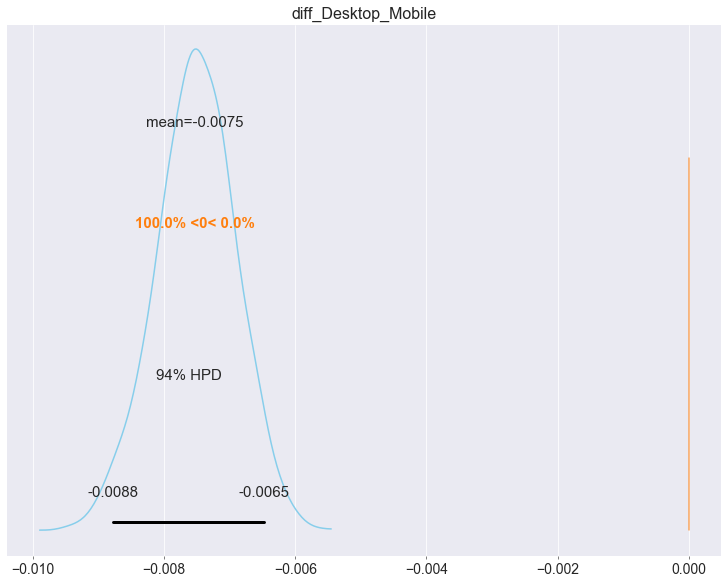

In [266]:
test.absim('home','pay','device')

test.summary

plot_posterior(test.trace, 'diff_Desktop_Mobile')


In [4]:
ex = mab(n_option=3) # default =2

In [5]:
print(ex.alpha)
print(ex.beta)
print(ex.n_option)

[1, 1, 1]
[1, 1, 1]
3


In [10]:
param = [0.2,0.5,0.7]
for i in range(1000):
    ex.update(ex.sample(),np.random.binomial(1,param[ex.sample()]))

In [11]:
ex.params()

                    parameters                    
 
option 0 : , alpha=24, beta=38
option 1 : , alpha=54, beta=61
option 2 : , alpha=1254, beta=575


In [12]:
ex.status()

         mu       var
0  0.387097  0.003766
1  0.469565  0.002147
2  0.685621  0.000118


         mu       var
0  0.387097  0.003766
1  0.469565  0.002147
2  0.685621  0.000118


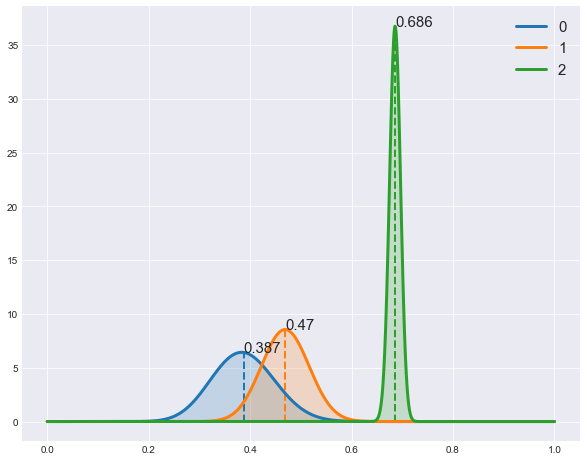

In [15]:
ex.status(plot=True)